In [132]:
!pip install pypdf

## [Dependencies]

In [142]:
import re
import numpy             as np
import pandas            as pd
import seaborn           as sns
import networkx          as nx
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain

from os                  import walk
from pypdf               import PdfReader
from itertools           import combinations
from tqdm.notebook       import tqdm
from networkx.algorithms import bipartite


## [Dataset creation]

In [134]:
filenames = next(walk('drive/MyDrive/2024-MO412A-project/files/'), (None, None, []))[2]
all_df = []

for file in tqdm(filenames, total=len(filenames)):
  reader = PdfReader(f'drive/MyDrive/2024-MO412A-project/files/{file}')

  for page in reader.pages:
    text = page.extract_text()

    seq_date_match = re.search(r'Seq:(\d{2}/\d{2}/\d{4})\s+(\d+)', text, re.IGNORECASE)
    materia_match = re.search(r'Seq:\d{2}/\d{2}/\d{4}\s+\d+\n(.+?)\nData:', text, re.S)
    ementa_match = re.search(r'Ementa:\s*(.+?)\s+Descrição:', text, re.S)
    descricao_match = re.search(r'Descrição:\s*(.+?)\s+SENADOR', text, re.S)

    table_pattern = r'^(.+?)\s+([A-Z]{2})\s+([A-Z/]+)\s+([^\n]+)$'
    table_matches = re.findall(table_pattern, text, re.M)

    senador = []
    distrito = []
    partido = []
    voto = []

    for match in table_matches:
      senador.append(match[0])
      distrito.append(match[1])
      partido.append(match[2])
      voto.append(match[3])

    df = pd.DataFrame({
      'senador': senador,
      'distrito': distrito,
      'partido': partido,
      'voto': voto,
      'descricao': descricao_match.group(1).strip() if descricao_match else None,
      'ementa': ementa_match.group(1).strip() if ementa_match else None,
      'materia': materia_match.group(1).strip() + '-' + seq_date_match.group(2).strip() if materia_match else None,
      'data': seq_date_match.group(1).strip() if seq_date_match else None,
      'sequencia': seq_date_match.group(2).strip() if seq_date_match else None
    })

    all_df.append(df)

all_df = pd.concat(all_df, ignore_index=True)
all_df = all_df[all_df.senador != 'SENADOR']
all_df.head(10)

  0%|          | 0/128 [00:00<?, ?it/s]

senador distrito partido   voto  \
1         Mailza Gomes       AC      PP    Sim   
2       Sérgio Petecão       AC     PSD  P-NRV   
3      Fernando Collor       AL     PTB    Sim   
4      Renan Calheiros       AL     MDB    Sim   
5        Eduardo Braga       AM     MDB    Sim   
6            Omar Aziz       AM     PSD  P-NRV   
7       Plínio Valério       AM    PSDB  P-NRV   
8        Lucas Barreto       AP     PSD    Sim   
9   Randolfe Rodrigues       AP    REDE    Não   
10      Angelo Coronel       BA     PSD    Sim   

                                            descricao  \
1   Votação nominal do Projeto de Lei nº 3.846, de...   
2   Votação nominal do Projeto de Lei nº 3.846, de...   
3   Votação nominal do Projeto de Lei nº 3.846, de...   
4   Votação nominal do Projeto de Lei nº 3.846, de...   
5   Votação nominal do Projeto de Lei nº 3.846, de...   
6   Votação nominal do Projeto de Lei nº 3.846, de...   
7   Votação nominal do Projeto de Lei nº 3.846, de...   
8   Votação nominal do Projeto de Lei nº 3.846, de...   
9   Votação nominal do Projeto de Lei nº 3.846, de...   
10  Votação nominal do Projeto de Lei nº 3.846, de...   

                                               ementa         materia  \
1   Altera a Lei nº 11.903, de 14 de janeiro de 20...  PL 3846/2021-1   
2   Altera a Lei nº 11.903, de 14 de janeiro de 20...  PL 3846/2021-1   
3   Altera a Lei nº 11.903, de 14 de janeiro de 20...  PL 3846/2021-1   
4   Altera a Lei nº 11.903, de 14 de janeiro de 20...  PL 3846/2021-1   
5   Altera a Lei nº 11.903, de 14 de janeiro de 20...  PL 3846/2021-1   
6   Altera a Lei nº 11.903, de 14 de janeiro de 20...  PL 3846/2021-1   
7   Altera a Lei nº 11.903, de 14 de janeiro de 20...  PL 3846/2021-1   
8   Altera a Lei nº 11.903, de 14 de janeiro de 20...  PL 3846/2021-1   
9   Altera a Lei nº 11.903, de 14 de janeiro de 20...  PL 3846/2021-1   
10  Altera a Lei nº 11.903, de 14 de janeiro de 20...  PL 3846/2021-1   

          data sequencia  
1   12/04/2022         1  
2   12/04/2022         1  
3   12/04/2022         1  
4   12/04/2022         1  
5   12/04/2022         1  
6   12/04/2022         1  
7   12/04/2022         1  
8   12/04/2022         1  
9   12/04/2022         1  
10  12/04/2022         1

In [135]:
print(f'Total de Projetos de Lei: {all_df.materia.nunique()}')
print(f'Total de Senadores:       {all_df.senador.nunique()}')
print(f'Total de Partidos:        {all_df.partido.nunique()}')
print(f'Total de Distritos:       {all_df.distrito.nunique()}')

Total de Projetos de Lei: 125
Total de Senadores:       124
Total de Partidos:        19
Total de Distritos:       27


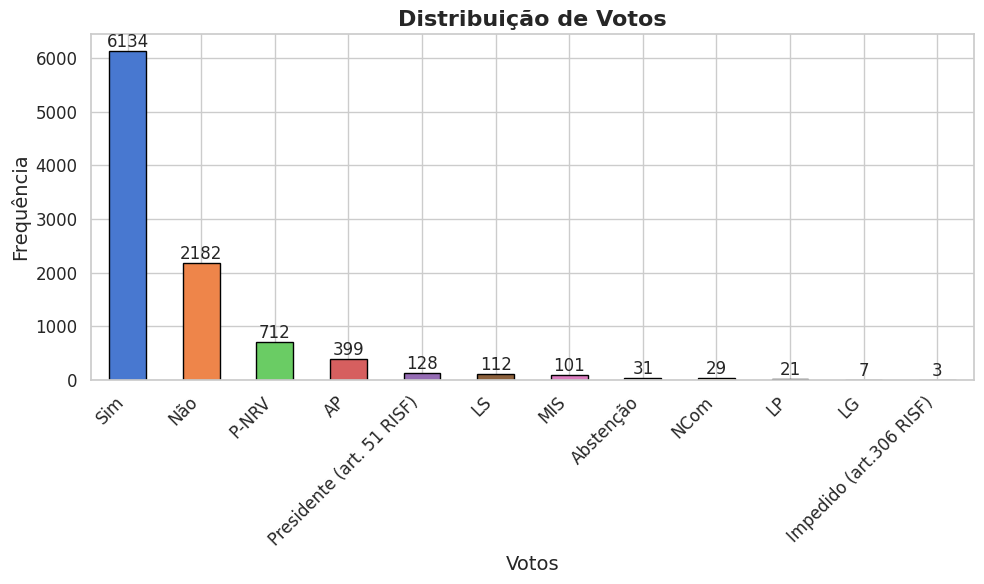

In [136]:
sns.set_theme(style="whitegrid")

ax = all_df.voto.value_counts().plot(
  kind='bar',
  color=sns.color_palette("muted"),
  figsize=(10, 6),
  edgecolor='black'
)

ax.set_title("Distribuição de Votos", fontsize=16, fontweight='bold')
ax.set_xlabel("Votos", fontsize=14)
ax.set_ylabel("Frequência", fontsize=14)
ax.bar_label(ax.containers[0], fmt='%d', fontsize=12)

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()

In [137]:
final_df = all_df[(all_df.voto == 'Sim') | (all_df.voto == 'Não')].copy() # | (all_df.voto == 'Abstenção') | (all_df.voto == 'P-NRV')].copy()
#final_df.replace({'Sim': 'Sim', 'Não': 'Não', 'Abstenção': 'Abstenção', 'P-NRV': 'Abstenção'}, inplace=True)
final_df

senador distrito partido voto  \
1          Mailza Gomes       AC      PP  Sim   
3       Fernando Collor       AL     PTB  Sim   
4       Renan Calheiros       AL     MDB  Sim   
5         Eduardo Braga       AM     MDB  Sim   
8         Lucas Barreto       AP     PSD  Sim   
...                 ...      ...     ...  ...   
10236  Rogério Carvalho       SE      PT  Sim   
10237          Giordano       SP     MDB  Sim   
10238       José Aníbal       SP    PSDB  Sim   
10239     Mara Gabrilli       SP    PSDB  Sim   
10241             Irajá       TO     PSD  Sim   

                                               descricao  \
1      Votação nominal do Projeto de Lei nº 3.846, de...   
3      Votação nominal do Projeto de Lei nº 3.846, de...   
4      Votação nominal do Projeto de Lei nº 3.846, de...   
5      Votação nominal do Projeto de Lei nº 3.846, de...   
8      Votação nominal do Projeto de Lei nº 3.846, de...   
...                                                  ...   
10236  Votação nominal da PEC 10, de 2021, em primeir...   
10237  Votação nominal da PEC 10, de 2021, em primeir...   
10238  Votação nominal da PEC 10, de 2021, em primeir...   
10239  Votação nominal da PEC 10, de 2021, em primeir...   
10241  Votação nominal da PEC 10, de 2021, em primeir...   

                                                  ementa         materia  \
1      Altera a Lei nº 11.903, de 14 de janeiro de 20...  PL 3846/2021-1   
3      Altera a Lei nº 11.903, de 14 de janeiro de 20...  PL 3846/2021-1   
4      Altera a Lei nº 11.903, de 14 de janeiro de 20...  PL 3846/2021-1   
5      Altera a Lei nº 11.903, de 14 de janeiro de 20...  PL 3846/2021-1   
8      Altera a Lei nº 11.903, de 14 de janeiro de 20...  PL 3846/2021-1   
...                                                  ...             ...   
10236  Altera o inciso IV do § 2º do art. 4º da Emend...   PEC 10/2021-1   
10237  Altera o inciso IV do § 2º do art. 4º da Emend...   PEC 10/2021-1   
10238  Altera o inciso IV do § 2º do art. 4º da Emend...   PEC 10/2021-1   
10239  Altera o inciso IV do § 2º do art. 4º da Emend...   PEC 10/2021-1   
10241  Altera o inciso IV do § 2º do art. 4º da Emend...   PEC 10/2021-1   

             data sequencia  
1      12/04/2022         1  
3      12/04/2022         1  
4      12/04/2022         1  
5      12/04/2022         1  
8      12/04/2022         1  
...           ...       ...  
10236  09/12/2021         1  
10237  09/12/2021         1  
10238  09/12/2021         1  
10239  09/12/2021         1  
10241  09/12/2021         1  

[8316 rows x 9 columns]

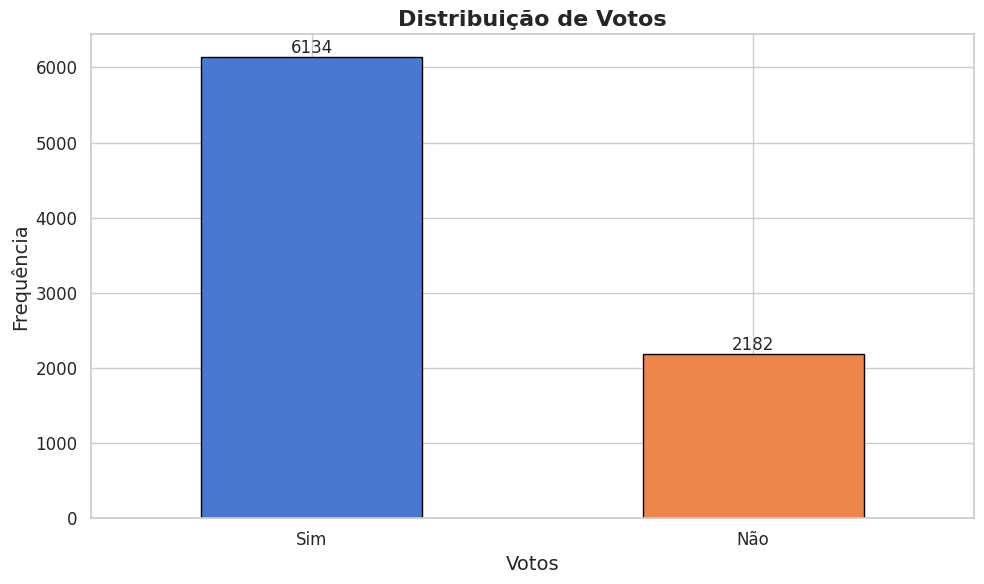

In [138]:
sns.set_theme(style="whitegrid")

ax = final_df.voto.value_counts().plot(
  kind='bar',
  color=sns.color_palette("muted"),
  figsize=(10, 6),
  edgecolor='black'
)

ax.set_title("Distribuição de Votos", fontsize=16, fontweight='bold')
ax.set_xlabel("Votos", fontsize=14)
ax.set_ylabel("Frequência", fontsize=14)
ax.bar_label(ax.containers[0], fmt='%d', fontsize=12)

plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()

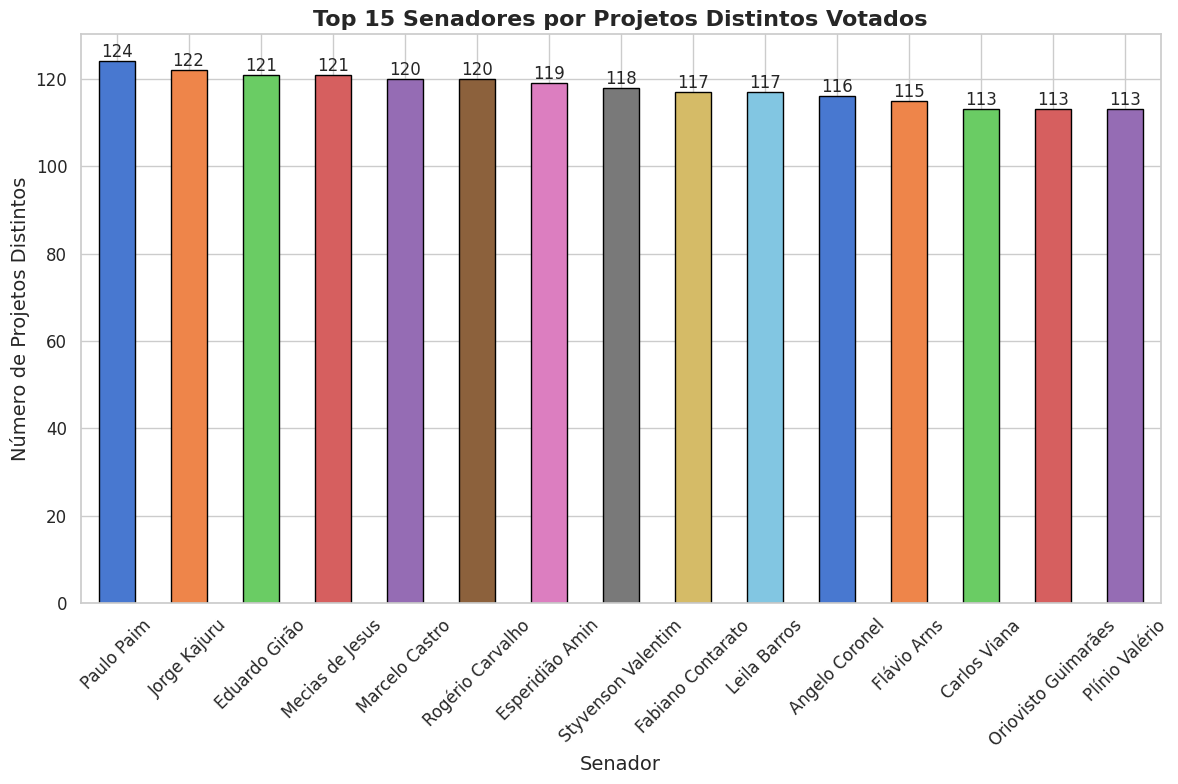

In [154]:
projetos_por_senador = final_df.groupby('senador')['materia'].nunique().sort_values(ascending=False)

sns.set_theme(style="whitegrid")

ax = projetos_por_senador.head(15).plot(  # Limite para os 15 senadores com mais projetos votados
    kind='bar',
    color=sns.color_palette("muted"),
    figsize=(12, 8),
    edgecolor='black'
)

ax.set_title("Top 15 Senadores por Projetos Distintos Votados", fontsize=16, fontweight='bold')
ax.set_xlabel("Senador", fontsize=14)
ax.set_ylabel("Número de Projetos Distintos", fontsize=14)

ax.bar_label(ax.containers[0], fmt='%d', fontsize=12)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


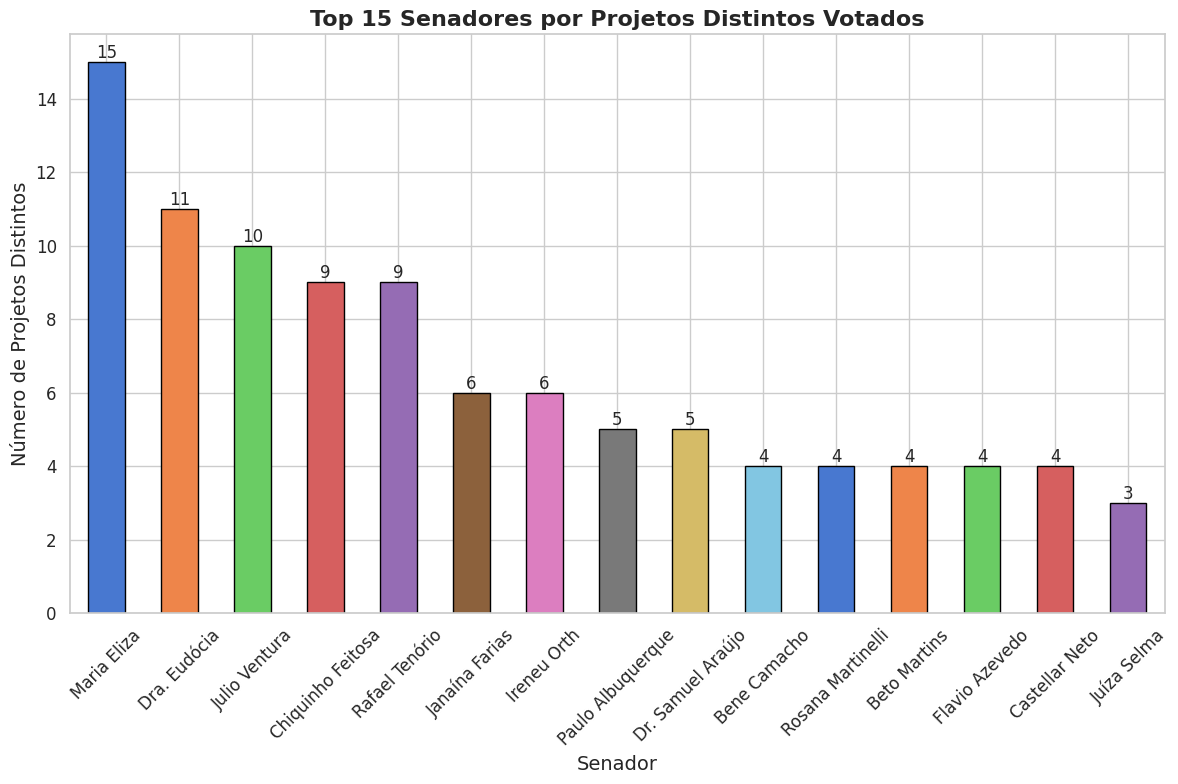

In [155]:
projetos_por_senador = final_df.groupby('senador')['materia'].nunique().sort_values(ascending=False)

sns.set_theme(style="whitegrid")

ax = projetos_por_senador.tail(15).plot(  # Limite para os 15 senadores com mais projetos votados
    kind='bar',
    color=sns.color_palette("muted"),
    figsize=(12, 8),
    edgecolor='black'
)

ax.set_title("Top 15 Senadores por Projetos Distintos Votados", fontsize=16, fontweight='bold')
ax.set_xlabel("Senador", fontsize=14)
ax.set_ylabel("Número de Projetos Distintos", fontsize=14)

ax.bar_label(ax.containers[0], fmt='%d', fontsize=12)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


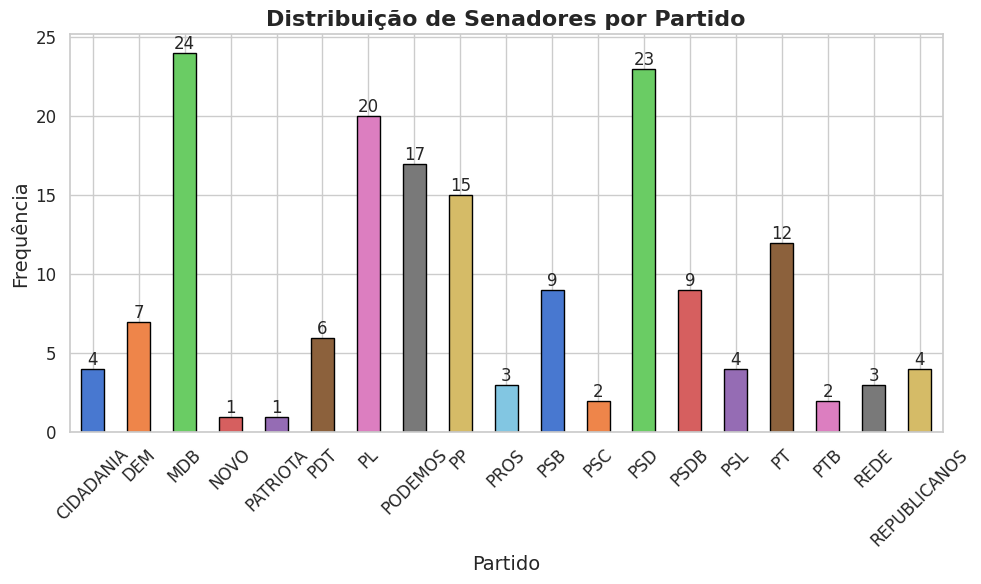

In [139]:
senadores_por_partido = final_df.groupby('partido')['senador'].nunique()
senadores_por_partido

sns.set_theme(style="whitegrid")

ax = senadores_por_partido.plot(
  kind='bar',
  color=sns.color_palette("muted"),
  figsize=(10, 6),
  edgecolor='black'
)

ax.set_title("Distribuição de Senadores por Partido", fontsize=16, fontweight='bold')
ax.set_xlabel("Partido", fontsize=14)
ax.set_ylabel("Frequência", fontsize=14)
ax.bar_label(ax.containers[0], fmt='%d', fontsize=12)

plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()

## [Graph Analysis]

### [All information]

#### [Visualization]

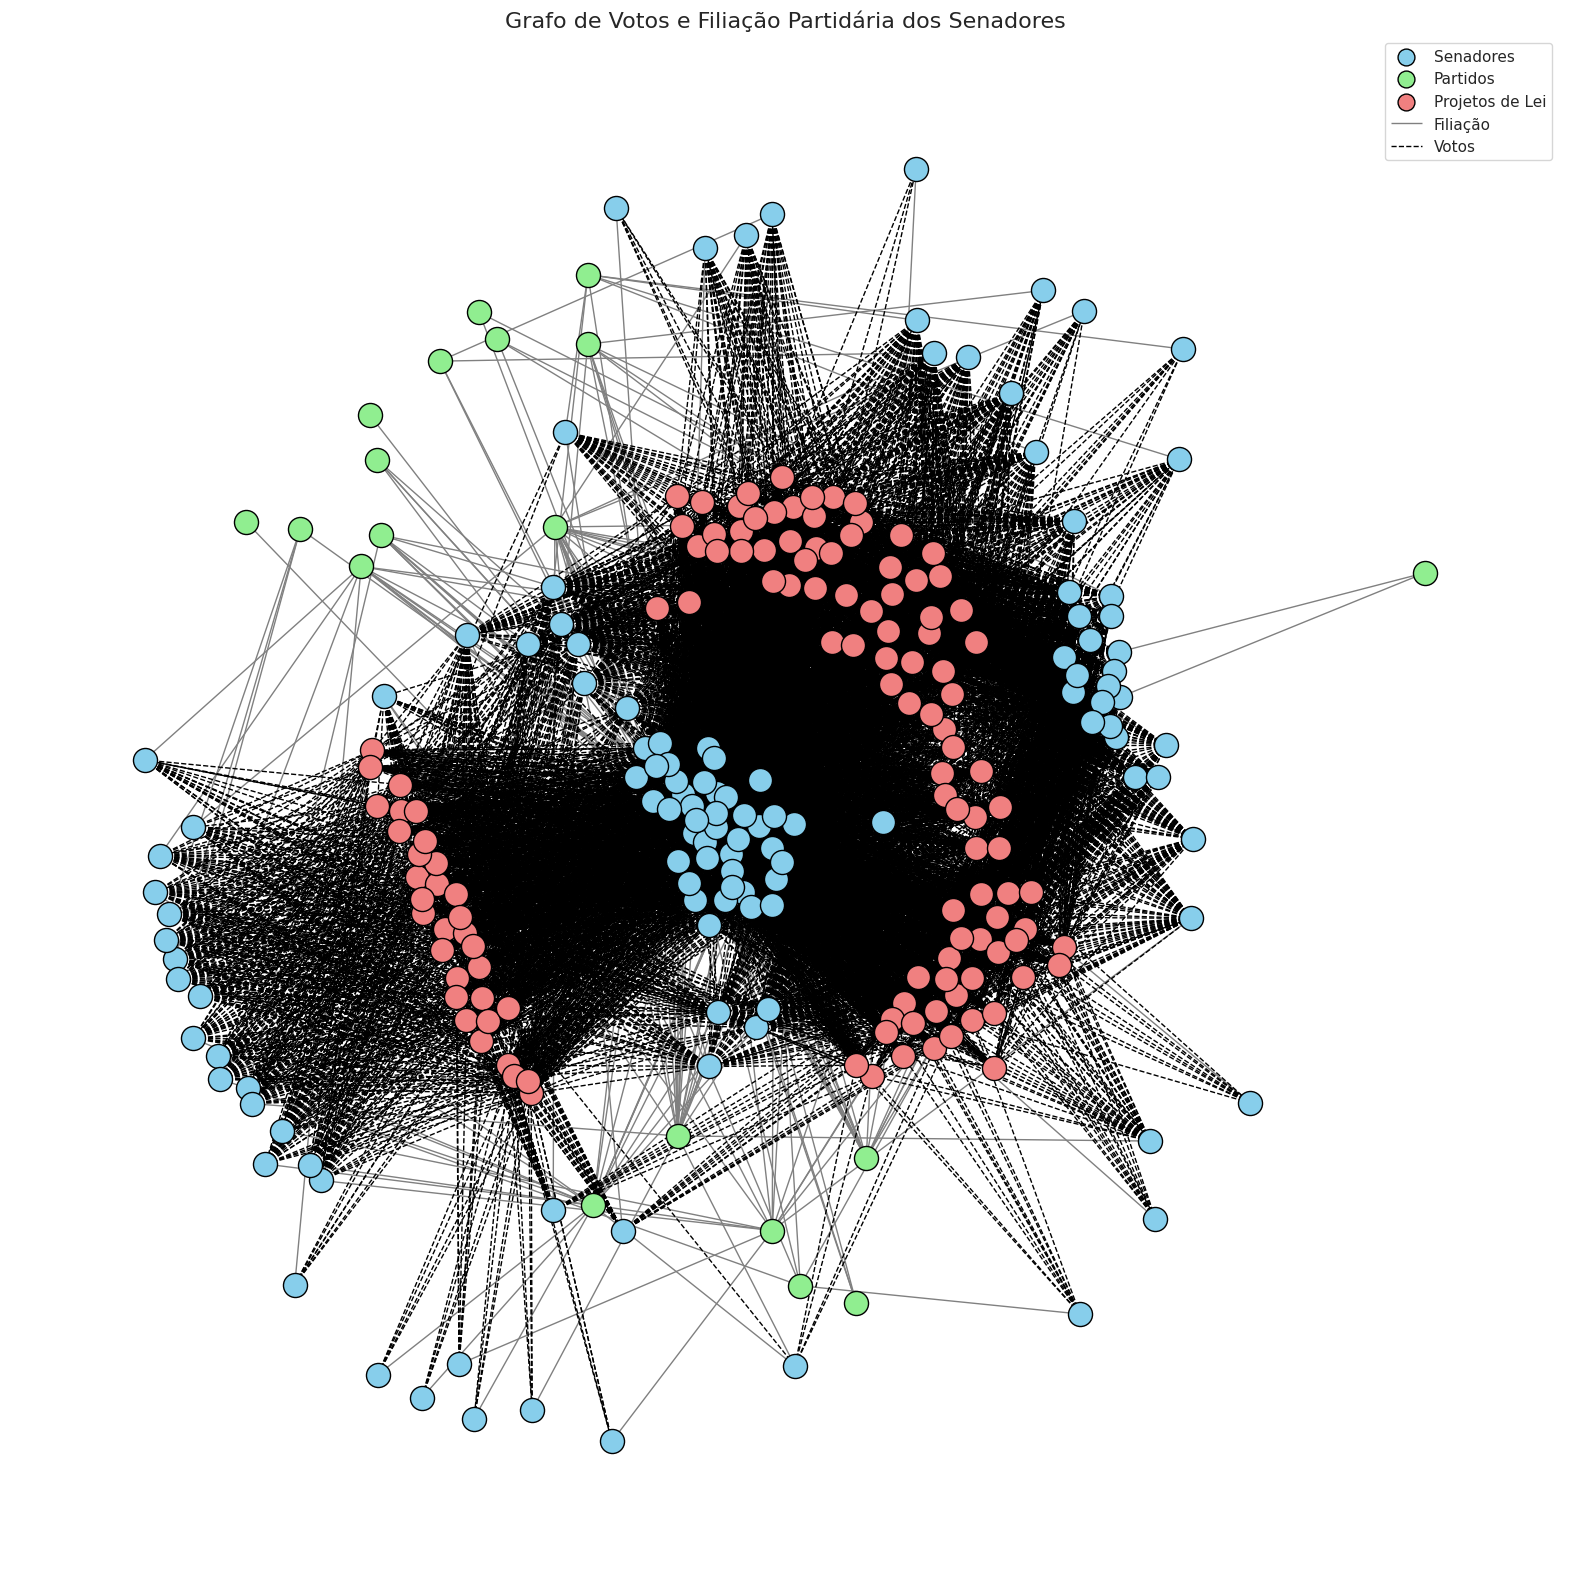

In [140]:
complete_graph = nx.Graph()

for _, row in final_df.iterrows():
    senador = row['senador']
    partido = row['partido']
    materia = row['materia']
    voto    = row['voto']

    complete_graph.add_node(senador, tipo='senador')
    complete_graph.add_node(partido, tipo='partido')
    complete_graph.add_node(materia, tipo='materia')

    complete_graph.add_edge(senador, partido, tipo='partido')
    complete_graph.add_edge(senador, materia, tipo='voto', voto=voto)

#nx.write_gexf(complete_graph, 'all_information.gexf')
#pos = nx.spring_layout(G, seed=42, k=2.5, iterations=100)

pos = nx.kamada_kawai_layout(complete_graph)
plt.figure(figsize=(20, 20))

senadores = [n for n, d in complete_graph.nodes(data=True) if d['tipo'] == 'senador']
partidos  = [n for n, d in complete_graph.nodes(data=True) if d['tipo'] == 'partido']
materias  = [n for n, d in complete_graph.nodes(data=True) if d['tipo'] == 'materia']

partido_edges = [(u, v) for u, v, d in complete_graph.edges(data=True) if d['tipo'] == 'partido']
voto_edges    = [(u, v) for u, v, d in complete_graph.edges(data=True) if d['tipo'] == 'voto']

nx.draw_networkx_nodes(complete_graph, pos, nodelist=senadores, node_color='skyblue', label='Senadores', node_size=300, edgecolors='black')
nx.draw_networkx_nodes(complete_graph, pos, nodelist=partidos, node_color='lightgreen', label='Partidos', node_size=300, edgecolors='black')
nx.draw_networkx_nodes(complete_graph, pos, nodelist=materias, node_color='lightcoral', label='Projetos de Lei', node_size=300, edgecolors='black')

nx.draw_networkx_edges(complete_graph, pos, edgelist=partido_edges, edge_color='gray', label='Filiação')
nx.draw_networkx_edges(complete_graph, pos, edgelist=voto_edges, edge_color='black', style='dashed', label='Votos')

plt.legend(markerscale=0.7, scatterpoints=1)
plt.title("Grafo de Votos e Filiação Partidária dos Senadores", fontsize=16)
plt.axis('off')
plt.show()


##### [Statistics]

In [148]:
## ----- Basic statistics ----- ##
num_nodes      = complete_graph.number_of_nodes()
num_edges      = complete_graph.number_of_edges()
degrees        = [degree for _, degree in complete_graph.degree()]
average_degree = np.mean(degrees)
max_degree     = np.max(degrees)

## ----- Centrality measures ----- ##
degree_centrality      = nx.degree_centrality(complete_graph)
betweenness_centrality = nx.betweenness_centrality(complete_graph)
closeness_centrality   = nx.closeness_centrality(complete_graph)

## ----- Average Path Lenght ----- ##
average_path_length = nx.average_shortest_path_length(complete_graph)
diameter            = nx.diameter(complete_graph)

clustering_coefficient = nx.average_clustering(complete_graph)

print("Graph Statistics:")
print(f"Number of nodes:        {num_nodes}")
print(f"Number of edges:        {num_edges}")
print(f"Average degree:         {average_degree}")
print(f"Maximum degree:         {max_degree}")
print(f"Average path length:    {average_path_length}")
print(f"Diameter:               {diameter}")
print(f"Clustering coefficient: {clustering_coefficient}")

print('-'*50)
print("\nCentrality Measures:")
print(f"Top 5 nodes by degree centrality:      {sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]}")
print(f"Top 5 nodes by betweenness centrality: {sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]}")
print(f"Top 5 nodes by closeness centrality:   {sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]}")


Graph Statistics:
Number of nodes:        267
Number of edges:        8276
Average degree:         61.99250936329588
Maximum degree:         125
Average path length:    2.115569823434992
Diameter:               5
Clustering coefficient: 0.0
--------------------------------------------------

Centrality Measures:
Top 5 nodes by degree centrality:      [('Jorge Kajuru', 0.4699248120300752), ('Paulo Paim', 0.4699248120300752), ('Eduardo Girão', 0.46240601503759393), ('Mecias de Jesus', 0.45864661654135336), ('Marcelo Castro', 0.4548872180451128)]
Top 5 nodes by betweenness centrality: [('Eduardo Girão', 0.018991542148603095), ('Mecias de Jesus', 0.01629496605789031), ('Leila Barros', 0.015591083296303107), ('Jorge Kajuru', 0.014976554944859189), ('Flávio Arns', 0.013615593313160944)]
Top 5 nodes by closeness centrality:   [('Jorge Kajuru', 0.6244131455399061), ('Paulo Paim', 0.6244131455399061), ('Eduardo Girão', 0.6186046511627907), ('Mecias de Jesus', 0.6157407407407407), ('Marcelo Cast

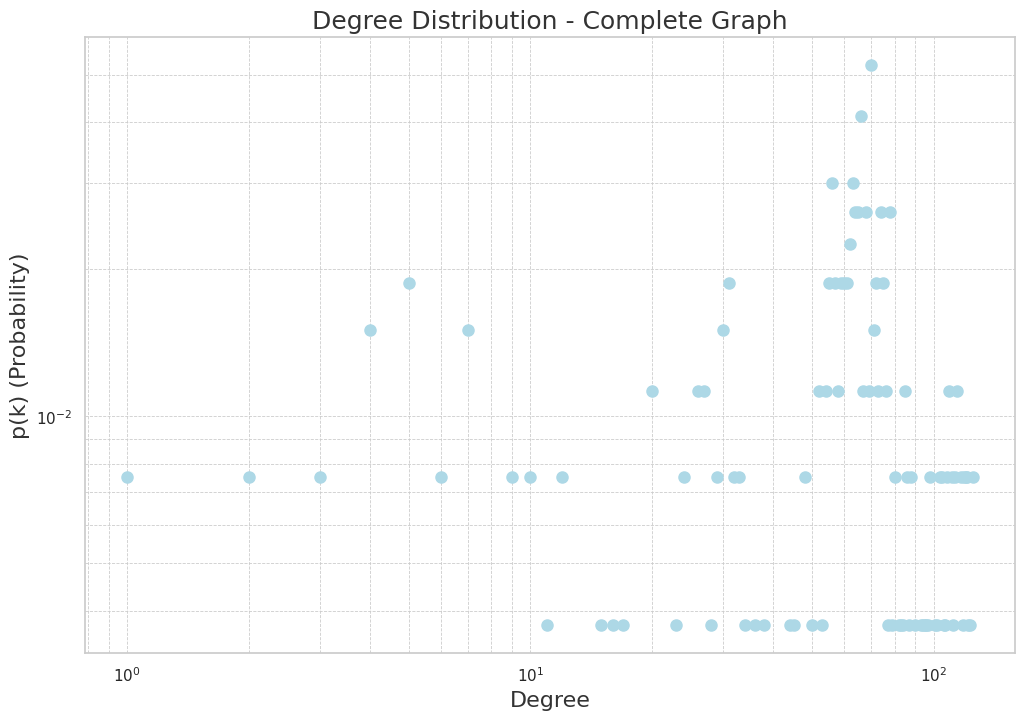

In [149]:
## ----- Degree Distribution ---- ##
degrees      = [degree for _, degree in complete_graph.degree()]
degree_count = np.bincount(degrees)
degrees      = np.arange(len(degree_count))

nonzero_degrees      = degrees[degree_count > 0]
nonzero_degree_count = degree_count[degree_count > 0]

total_nodes = complete_graph.number_of_nodes()
p_k         = nonzero_degree_count / total_nodes

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.family': 'DejaVu Sans', 'font.size': 14})

plt.loglog(nonzero_degrees, p_k, marker='o', linestyle='None', markersize=8, color='#ADD8E6')

plt.title("Degree Distribution - Complete Graph", fontsize=18, color='#333333')
plt.xlabel("Degree", fontsize=16, color='#333333')
plt.ylabel("p(k) (Probability)", fontsize=16, color='#333333')
plt.grid(True, which="both", linestyle="--", linewidth=0.6, color='#cccccc')

plt.show()

### [Only Senators]

In [159]:
votos_por_projeto = final_df.groupby('materia')['senador'].apply(list)

senators_graph = nx.Graph()

for _, senadores in votos_por_projeto.items():
  for s1, s2 in combinations(senadores, 2):
    if s1 == s2: continue
    if senators_graph.has_edge(s1, s2):
      senators_graph[s1][s2]['weight'] += 1
    else:
      senators_graph.add_edge(s1, s2, weight=1)

for senador in senators_graph.nodes:
  senators_graph.nodes[senador]['tipo'] = 'senador'

# nx.write_gexf(senators_graph, 'only_senators.gexf')

#### [Visualization]

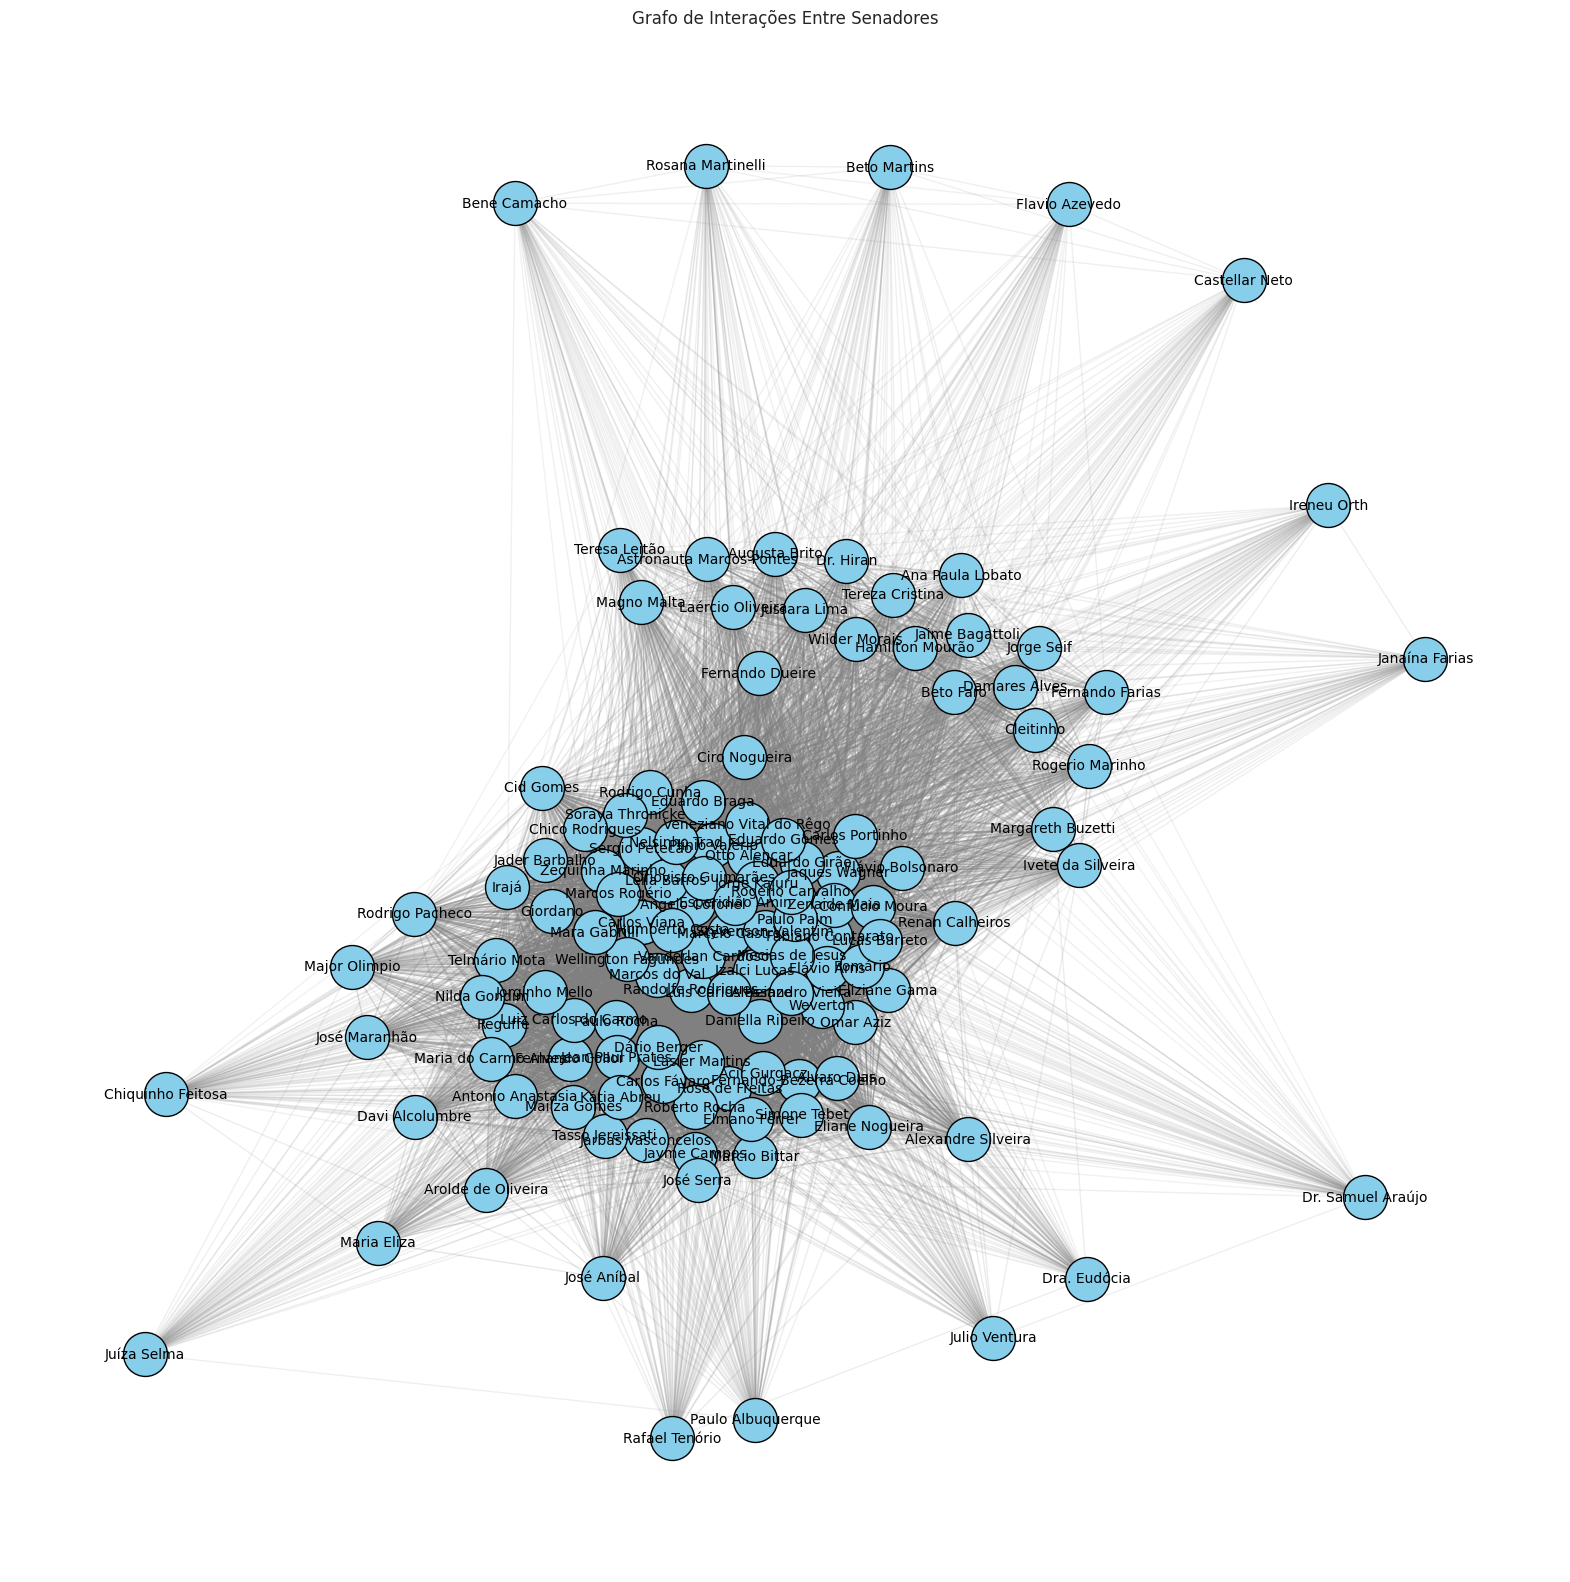

In [160]:
from sklearn.preprocessing import MinMaxScaler

#pos = nx.kamada_kawai_layout(G)
pos = nx.spring_layout(senators_graph, seed=42, k=3.5, iterations=400)

plt.figure(figsize=(20, 20))

edge_weights = [senators_graph[u][v]['weight'] for u, v in senators_graph.edges]

scaler = MinMaxScaler(feature_range=(0.1, 1))
normalized_weights = scaler.fit_transform([[weight] for weight in edge_weights]).flatten()

nx.draw_networkx_nodes(senators_graph, pos, node_size=1000, node_color='skyblue', edgecolors='black')
nx.draw_networkx_edges(senators_graph, pos, width=1, alpha=normalized_weights, edge_color='grey')

nx.draw_networkx_labels(senators_graph, pos, font_size=10, font_color='black')

plt.title("Grafo de Interações Entre Senadores")
plt.axis('off')
plt.show()


In [164]:
## ----- Basic statistics ----- ##
num_nodes      = senators_graph.number_of_nodes()
num_edges      = senators_graph.number_of_edges()
degrees        = [degree for _, degree in senators_graph.degree(weight='weight')]
average_degree = np.mean(degrees)
max_degree     = np.max(degrees)

## ----- Centrality measures ----- ##
degree_centrality      = nx.degree_centrality(senators_graph)
betweenness_centrality = nx.betweenness_centrality(senators_graph, weight='weight', normalized=True)
closeness_centrality   = nx.closeness_centrality(senators_graph, distance='weight')

## ----- Average Path Length ----- ##
average_path_length = nx.average_shortest_path_length(senators_graph, weight='weight')
diameter            = nx.diameter(senators_graph)

# Coeficiente de clustering médio
clustering_coefficient = nx.average_clustering(senators_graph, weight='weight')

# Exibir resultados
print("Graph Statistics:")
print(f"Number of nodes:        {num_nodes}")
print(f"Number of edges:        {num_edges}")
print(f"Average degree:         {average_degree:.2f}")
print(f"Maximum degree:         {max_degree}")
print(f"Average path length:    {average_path_length if average_path_length else 'Graph not connected'}")
print(f"Diameter:               {diameter if diameter else 'Graph not connected'}")
print(f"Clustering coefficient: {clustering_coefficient:.2f}")

print('-' * 50)
print("\nCentrality Measures:")
print(f"Top 5 nodes by degree centrality:      {sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]}")
print(f"Top 5 nodes by betweenness centrality: {sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]}")
print(f"Top 5 nodes by closeness centrality:   {sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]}")


Graph Statistics:
Number of nodes:        123
Number of edges:        6178
Average degree:         4628.63
Maximum degree:         8554
Average path length:    6.35985605757697
Diameter:               2
Clustering coefficient: 0.29
--------------------------------------------------

Centrality Measures:
Top 5 nodes by degree centrality:      [('Sérgio Petecão', 1.0), ('Eduardo Braga', 1.0), ('Plínio Valério', 1.0), ('Angelo Coronel', 1.0), ('Jaques Wagner', 1.0)]
Top 5 nodes by betweenness centrality: [('Dr. Samuel Araújo', 0.3791336002328588), ('Juíza Selma', 0.2958262734295876), ('Rodrigo Pacheco', 0.06386700133841046), ('Carlos Fávaro', 0.0558508404599463), ('Chiquinho Feitosa', 0.0373473033917777)]
Top 5 nodes by closeness centrality:   [('Dr. Samuel Araújo', 0.25363825363825365), ('Juíza Selma', 0.23968565815324164), ('Margareth Buzetti', 0.2222222222222222), ('Carlos Fávaro', 0.22141560798548093), ('Magno Malta', 0.21942446043165467)]


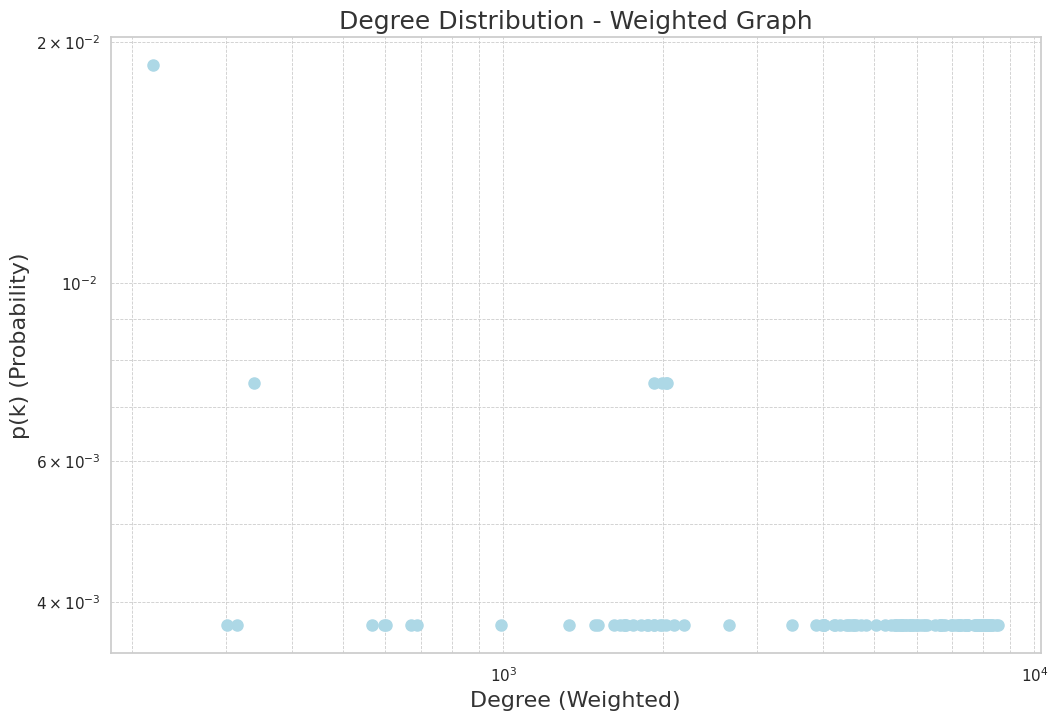

In [166]:
# ----- Degree Distribution Considering Edge Weights ---- ##
weighted_degrees = [sum(weight for _, _, weight in senators_graph.edges(n, data='weight')) for n in senators_graph.nodes()]

degree_count = np.bincount(weighted_degrees)
degrees      = np.arange(len(degree_count))

nonzero_degrees      = degrees[degree_count > 0]
nonzero_degree_count = degree_count[degree_count > 0]

total_nodes = complete_graph.number_of_nodes()
p_k         = nonzero_degree_count / total_nodes

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.family': 'DejaVu Sans', 'font.size': 14})

plt.loglog(nonzero_degrees, p_k, marker='o', linestyle='None', markersize=8, color='#ADD8E6')

plt.title("Degree Distribution - Weighted Graph", fontsize=18, color='#333333')
plt.xlabel("Degree (Weighted)", fontsize=16, color='#333333')
plt.ylabel("p(k) (Probability)", fontsize=16, color='#333333')
plt.grid(True, which="both", linestyle="--", linewidth=0.6, color='#cccccc')

plt.show()


In [176]:
!pip install python-louvain

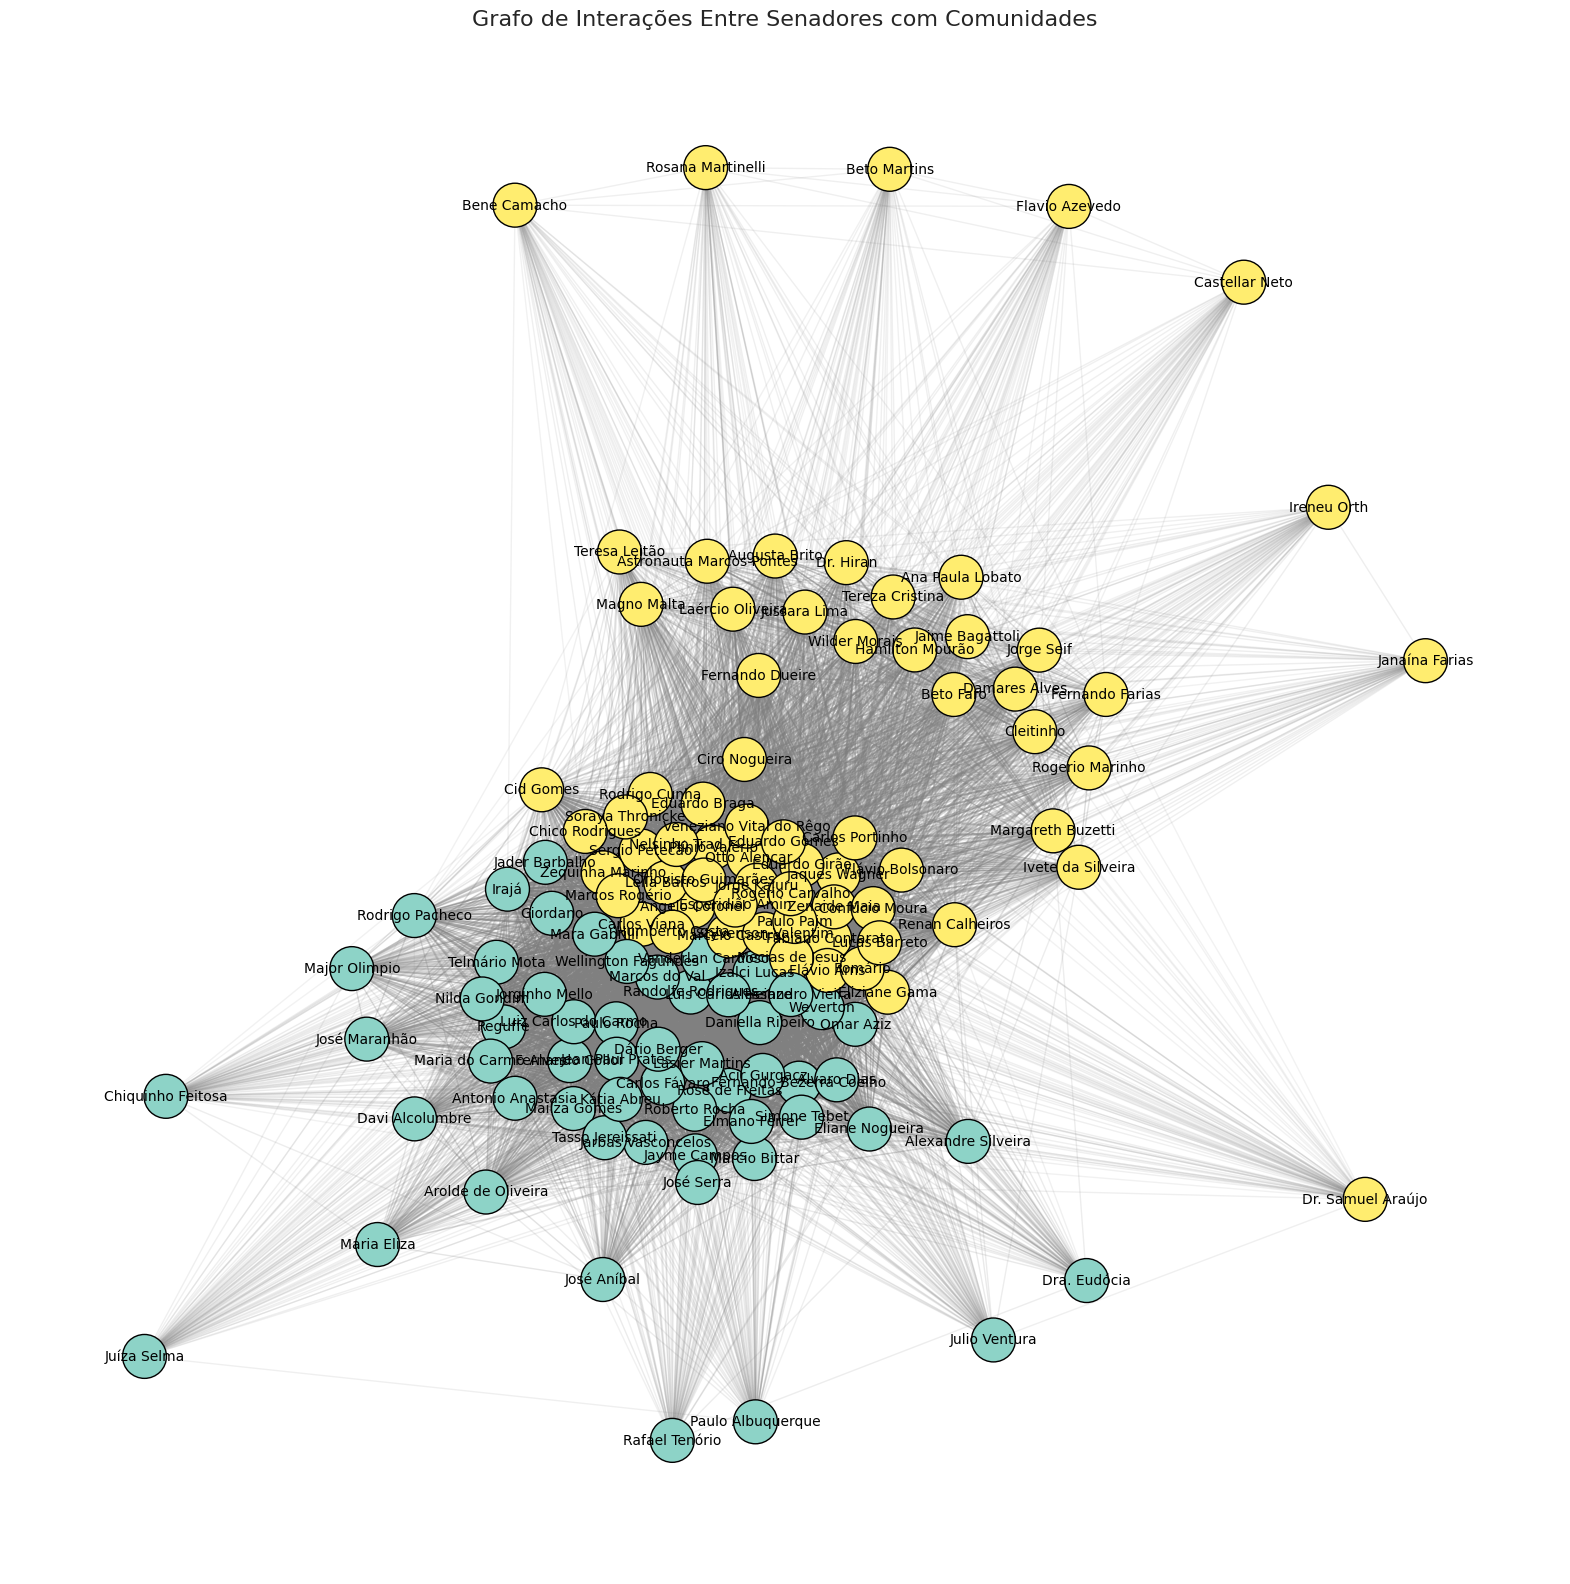

In [179]:
partition = community_louvain.best_partition(senators_graph, weight='weight')

community_groups = {}
for node, community in partition.items():
    if community not in community_groups:
        community_groups[community] = []
    community_groups[community].append(node)

pos = nx.spring_layout(senators_graph, seed=42, k=3.5, iterations=400)

plt.figure(figsize=(20, 20))
edge_weights = [senators_graph[u][v]['weight'] for u, v in senators_graph.edges]

scaler = MinMaxScaler(feature_range=(0.1, 1))
normalized_weights = scaler.fit_transform([[weight] for weight in edge_weights]).flatten()

colors = [partition[node] for node in senators_graph.nodes()]
nx.draw_networkx_nodes(senators_graph, pos, node_size=1000, node_color=colors, cmap=plt.cm.Set3, edgecolors='black')
nx.draw_networkx_edges(senators_graph, pos, width=1, alpha=normalized_weights, edge_color='grey')
nx.draw_networkx_labels(senators_graph, pos, font_size=10, font_color='black')

plt.title("Grafo de Interações Entre Senadores com Comunidades", fontsize=16)
plt.axis('off')
plt.show()


### [Partidos]

In [168]:
votos_por_projeto = final_df.groupby('materia').apply(lambda df: df.drop_duplicates(subset=['senador'])['partido'].tolist())

parties_graph = nx.Graph()

for _, partidos in votos_por_projeto.items():
  for p1, p2 in combinations(partidos, 2):
    if parties_graph.has_edge(p1, p2):
      parties_graph[p1][p2]['weight'] += 1
    else:
      parties_graph.add_edge(p1, p2, weight=1)

for partido in parties_graph.nodes:
  parties_graph.nodes[partido]['tipo'] = 'partido'

# nx.write_gexf(parties_graph, 'only_parties_unique.gexf')

<ipython-input-168-a2566fcb0850>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  votos_por_projeto = final_df.groupby('materia').apply(lambda df: df.drop_duplicates(subset=['senador'])['partido'].tolist())


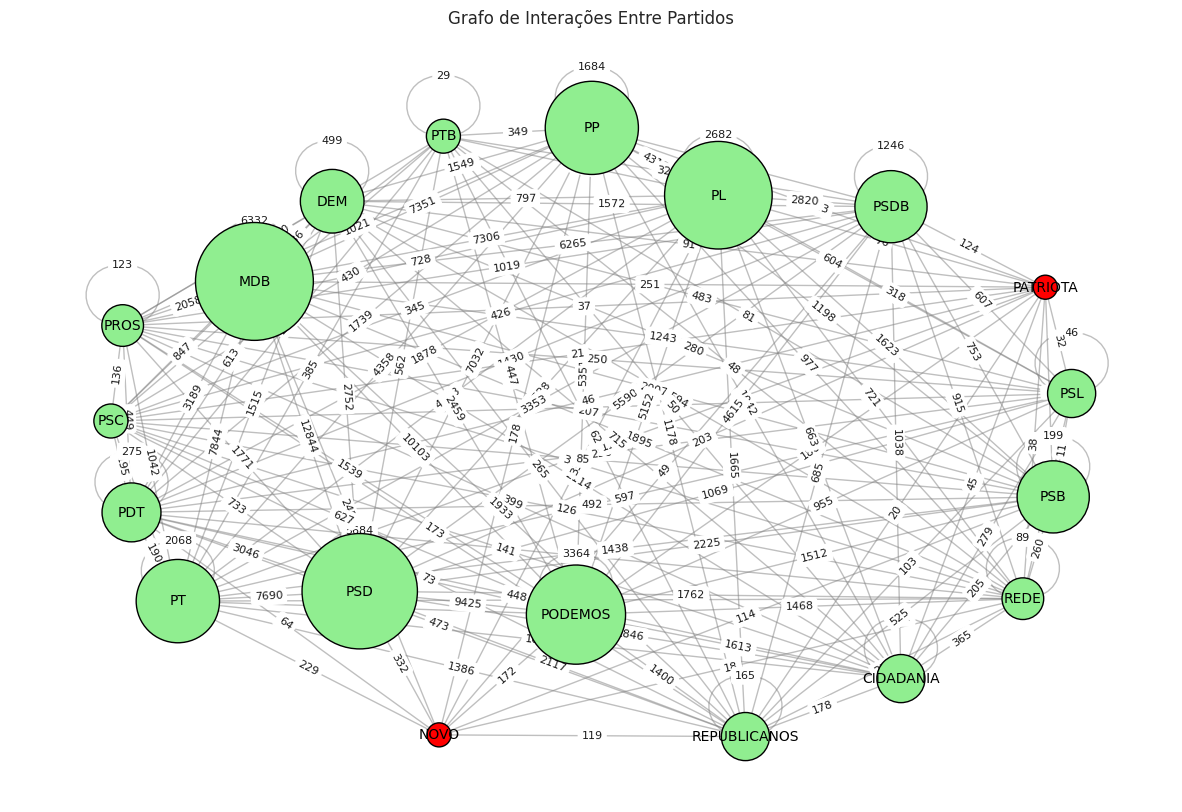

In [173]:
senadores_por_partido = final_df.groupby('partido')['senador'].nunique()

node_sizes  = [senadores_por_partido[partido] * 300 for partido in parties_graph.nodes]
node_colors = ['red' if senadores_por_partido[partido] == 1 else 'lightgreen' for partido in parties_graph.nodes]

pos = nx.spring_layout(parties_graph, seed=42, k=100, iterations=100)

plt.figure(figsize=(15, 10))
edges = nx.draw_networkx_edges(parties_graph, pos, alpha=0.5, edge_color='gray')
nodes = nx.draw_networkx_nodes(
    parties_graph, pos,
    node_size=node_sizes,
    node_color=node_colors,
    edgecolors='black'
)
labels = nx.draw_networkx_labels(parties_graph, pos, font_size=10, font_color='black')

edge_labels = nx.get_edge_attributes(parties_graph, 'weight')
nx.draw_networkx_edge_labels(parties_graph, pos, edge_labels=edge_labels, font_size=8)

plt.title("Grafo de Interações Entre Partidos")
plt.axis('off')
plt.show()


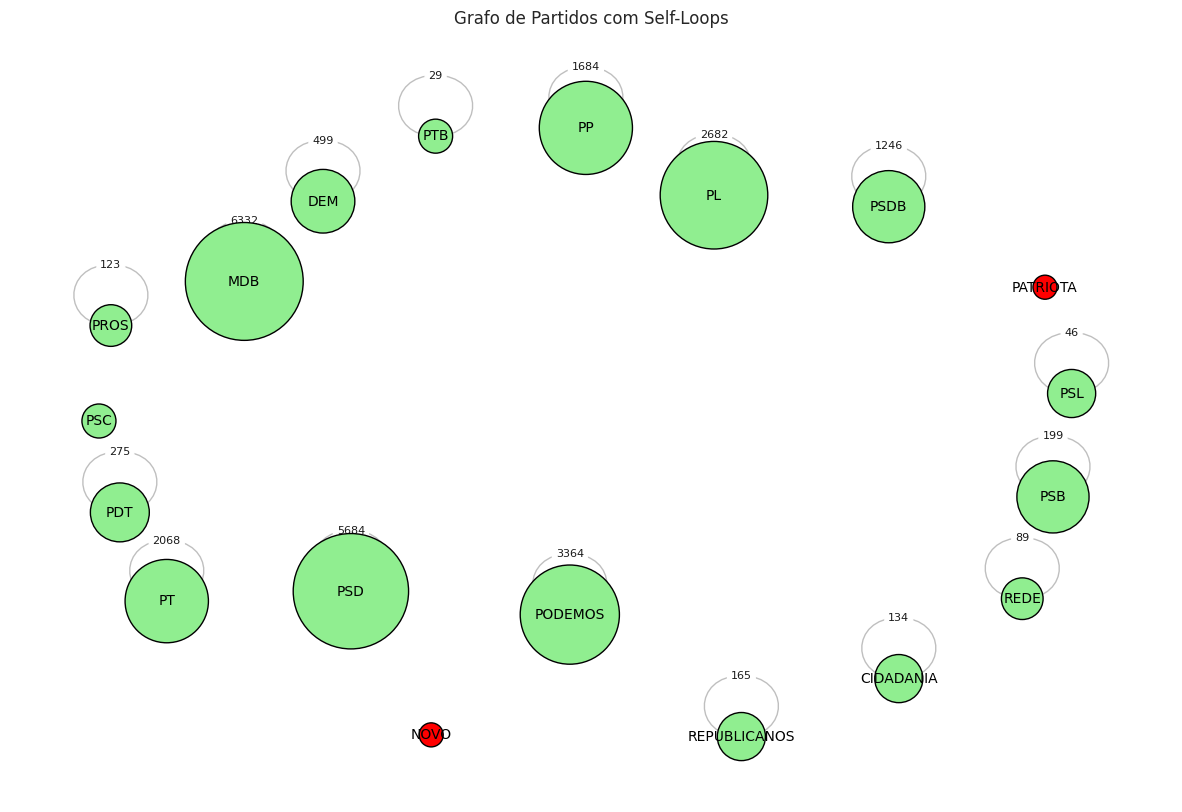

In [174]:
senadores_por_partido = final_df.groupby('partido')['senador'].nunique()

node_sizes  = [senadores_por_partido[partido] * 300 for partido in parties_graph.nodes]
node_colors = ['red' if senadores_por_partido[partido] == 1 else 'lightgreen' for partido in parties_graph.nodes]

self_loops = [(u, v) for u, v in parties_graph.edges if u == v]

pos = nx.spring_layout(parties_graph, seed=42, k=100, iterations=100)

plt.figure(figsize=(15, 10))
edges = nx.draw_networkx_edges(parties_graph, pos, edgelist=self_loops, alpha=0.5, edge_color='gray')
nodes = nx.draw_networkx_nodes(
    parties_graph, pos,
    node_size=node_sizes,
    node_color=node_colors,
    edgecolors='black'
)
labels = nx.draw_networkx_labels(parties_graph, pos, font_size=10, font_color='black')

edge_labels = {edge: parties_graph.edges[edge]['weight'] for edge in self_loops}
nx.draw_networkx_edge_labels(parties_graph, pos, edge_labels=edge_labels, font_size=8)

plt.title("Grafo de Partidos com Self-Loops")
plt.axis('off')
plt.show()


In [171]:
## ----- Basic statistics ----- ##
num_nodes      = parties_graph.number_of_nodes()
num_edges      = parties_graph.number_of_edges()
degrees        = [degree for _, degree in parties_graph.degree(weight='weight')]
average_degree = np.mean(degrees)
max_degree     = np.max(degrees)

## ----- Centrality measures ----- ##
degree_centrality      = nx.degree_centrality(parties_graph)
betweenness_centrality = nx.betweenness_centrality(parties_graph, weight='weight', normalized=True)
closeness_centrality   = nx.closeness_centrality(parties_graph, distance='weight')

## ----- Average Path Length ----- ##
average_path_length = nx.average_shortest_path_length(parties_graph, weight='weight')
diameter            = nx.diameter(parties_graph)

# Coeficiente de clustering médio
clustering_coefficient = nx.average_clustering(parties_graph, weight='weight')

# Exibir resultados
print("Graph Statistics:")
print(f"Number of nodes:        {num_nodes}")
print(f"Number of edges:        {num_edges}")
print(f"Average degree:         {average_degree:.2f}")
print(f"Maximum degree:         {max_degree}")
print(f"Average path length:    {average_path_length if average_path_length else 'Graph not connected'}")
print(f"Diameter:               {diameter if diameter else 'Graph not connected'}")
print(f"Clustering coefficient: {clustering_coefficient:.2f}")

print('-' * 50)
print("\nCentrality Measures:")
print(f"Top 5 nodes by degree centrality:      {sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]}")
print(f"Top 5 nodes by betweenness centrality: {sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]}")
print(f"Top 5 nodes by closeness centrality:   {sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]}")


Graph Statistics:
Number of nodes:        19
Number of edges:        177
Average degree:         27632.00
Maximum degree:         83987
Average path length:    152.95906432748538
Diameter:               2
Clustering coefficient: 0.08
--------------------------------------------------

Centrality Measures:
Top 5 nodes by degree centrality:      [('PP', 1.1111111111111112), ('PSD', 1.1111111111111112), ('PSDB', 1.1111111111111112), ('MDB', 1.1111111111111112), ('REDE', 1.1111111111111112)]
Top 5 nodes by betweenness centrality: [('PATRIOTA', 0.8431372549019608), ('REDE', 0.16993464052287582), ('NOVO', 0.1503267973856209), ('PSC', 0.058823529411764705), ('PP', 0.0)]
Top 5 nodes by closeness centrality:   [('PATRIOTA', 0.011904761904761904), ('PSB', 0.01139240506329114), ('REPUBLICANOS', 0.00989010989010989), ('PSC', 0.009852216748768473), ('REDE', 0.009544008483563097)]


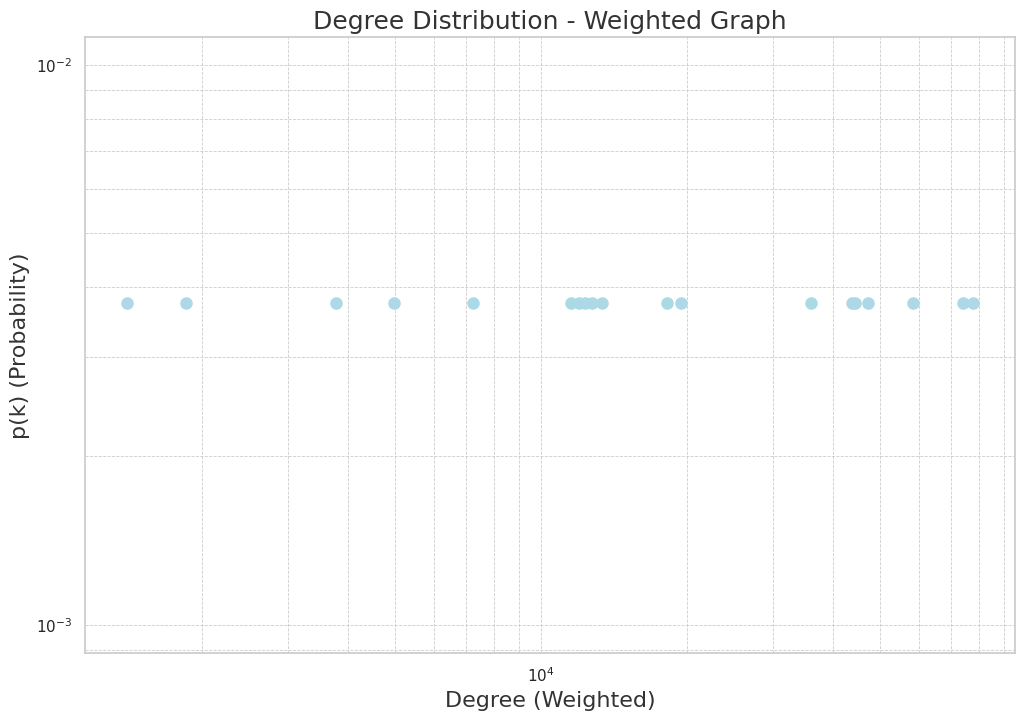

In [172]:
# ----- Degree Distribution Considering Edge Weights ---- ##
weighted_degrees = [sum(weight for _, _, weight in parties_graph.edges(n, data='weight')) for n in parties_graph.nodes()]

degree_count = np.bincount(weighted_degrees)
degrees      = np.arange(len(degree_count))

nonzero_degrees      = degrees[degree_count > 0]
nonzero_degree_count = degree_count[degree_count > 0]

total_nodes = complete_graph.number_of_nodes()
p_k         = nonzero_degree_count / total_nodes

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.family': 'DejaVu Sans', 'font.size': 14})

plt.loglog(nonzero_degrees, p_k, marker='o', linestyle='None', markersize=8, color='#ADD8E6')

plt.title("Degree Distribution - Weighted Graph", fontsize=18, color='#333333')
plt.xlabel("Degree (Weighted)", fontsize=16, color='#333333')
plt.ylabel("p(k) (Probability)", fontsize=16, color='#333333')
plt.grid(True, which="both", linestyle="--", linewidth=0.6, color='#cccccc')

plt.show()


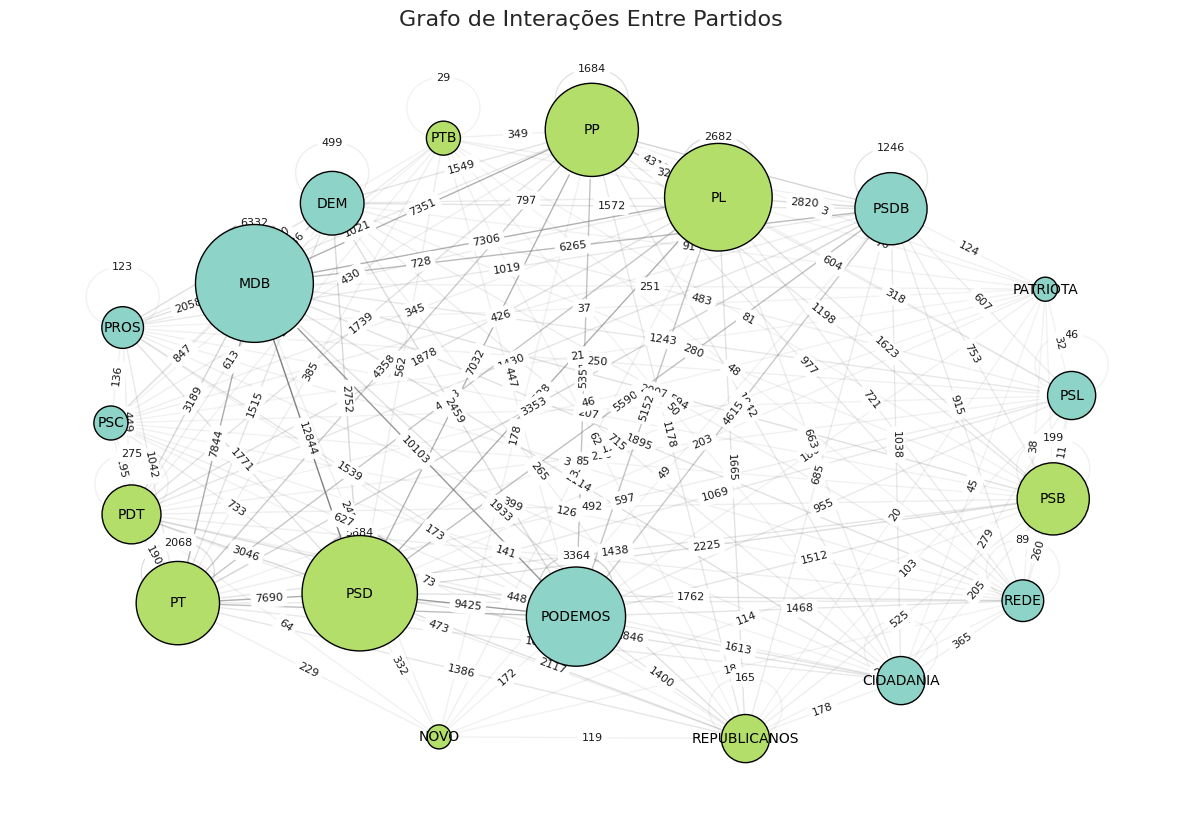

In [184]:
partition = community_louvain.best_partition(parties_graph, weight='weight')

community_groups = {}
for node, community in partition.items():
    if community not in community_groups:
        community_groups[community] = []
    community_groups[community].append(node)

community_colors = {community: plt.cm.Set3(community / len(community_groups)) for community in community_groups}

pos = nx.spring_layout(parties_graph, seed=42, k=100, iterations=100)

node_sizes = [senadores_por_partido[partido] * 300 for partido in parties_graph.nodes]

node_colors = [community_colors[partition[node]] for node in parties_graph.nodes]

plt.figure(figsize=(15, 10))

edge_weights = [parties_graph[u][v]['weight'] for u, v in parties_graph.edges]
scaler = MinMaxScaler(feature_range=(0.1, 1))
normalized_weights = scaler.fit_transform([[weight] for weight in edge_weights]).flatten()

nx.draw_networkx_nodes(parties_graph, pos, node_size=node_sizes, node_color=node_colors, edgecolors='black')
nx.draw_networkx_edges(parties_graph, pos, width=1, alpha=normalized_weights, edge_color='gray')
nx.draw_networkx_labels(parties_graph, pos, font_size=10, font_color='black')

edge_labels = nx.get_edge_attributes(parties_graph, 'weight')
nx.draw_networkx_edge_labels(parties_graph, pos, edge_labels=edge_labels, font_size=8)

plt.title("Grafo de Interações Entre Partidos", fontsize=16)
plt.axis('off')
plt.show()
